In [1]:
import exowrap
from exowrap.output import ExoremOut

# 1. You run your fast, low-res model
params = {"mass": 1.0, "T_int": 500, "T_irr": 1000, "Met": 0.0, "g_1bar": 10.0}
fast_model = exowrap.Simulation(params=params, resolution=50)
df_50 = fast_model.run()

# 2. You instantly upgrade it!
df_500 = exowrap.upgrade_resolution(
    results=df_50, 
    base_params=params, 
    target_resolution=500,
    output_dir="../tests/"
)

# 3. Analyze the new high-res spectrum
exo_high_res = ExoremOut(df_500)
print(f"Generated {len(exo_high_res.wavelength)} spectral points!")

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmp6vc8x7uc/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...
INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmp6vc8x7uc/outputs/exowrap_run.h5...
INFO: Simulation complete.
INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpmw_exhw5/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...


🚀 Upgrading simulation to R=500...
💾 Locked P-T profile saved to: data/high_res_spectra/locked_pt_profile.dat
⚡ Executing 0-iteration forward pass...


INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpmw_exhw5/outputs/exowrap_run.h5...
INFO: 💾 Permanently saved HDF5 to: data/high_res_spectra/exorem_Tint500_g10.0.h5
INFO: Simulation complete.


🎉 High-resolution upgrade complete!
Generated 1502 spectral points!


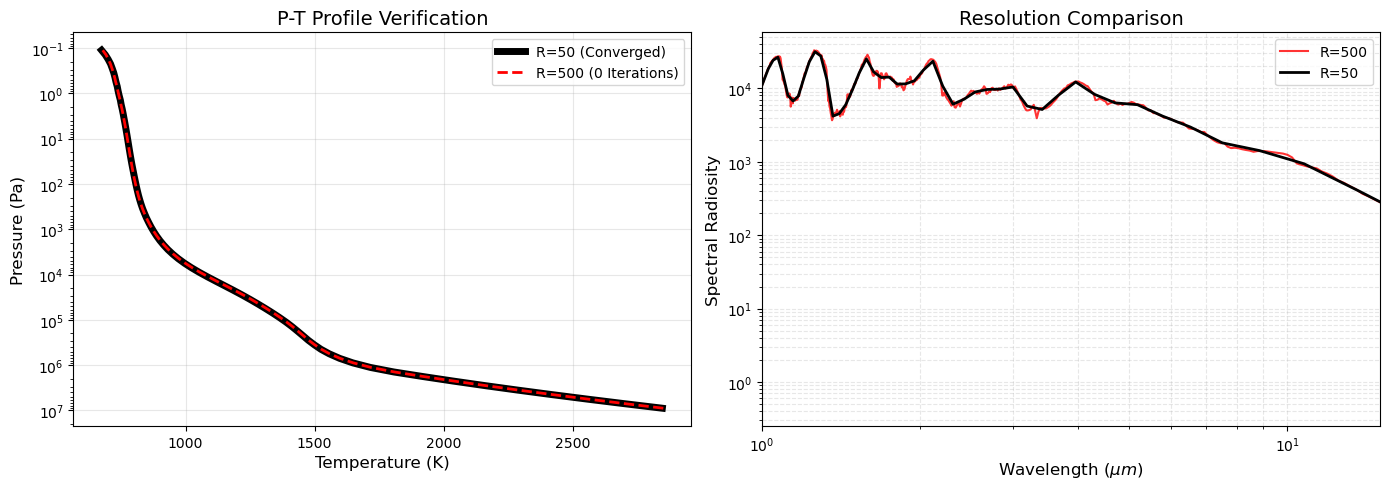

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from exowrap.output import ExoremOut

# 1. Wrap both DataFrames in our unit-aware object
exo_50 = ExoremOut(df_50)
exo_500 = ExoremOut(df_500)

# 2. Set up a side-by-side plot canvas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ==========================================
# PANEL 1: Verify the P-T Profile is Locked
# ==========================================
p_50 = exo_50.pressure_profile
t_50 = exo_50.temperature_profile
p_500 = exo_500.pressure_profile
t_500 = exo_500.temperature_profile

# Plot the baseline R=50 as a thick black line
axes[0].plot(t_50, p_50, lw=5, label="R=50 (Converged)", color="black")

# Overlay the upgraded R=500 as a thinner dashed red line
axes[0].plot(t_500, p_500, lw=2, label="R=500 (0 Iterations)", color="red", linestyle="--")

axes[0].set_yscale("log")
axes[0].invert_yaxis()
axes[0].set_xlabel("Temperature (K)", fontsize=12)
axes[0].set_ylabel("Pressure (Pa)", fontsize=12)
axes[0].set_title("P-T Profile Verification", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# ==========================================
# PANEL 2: Compare the Emission Spectra
# ==========================================
# We will manually extract and plot the flux here so we can customize the legend easily
def get_plot_arrays(exo):
    """Helper to extract and sort wavelength and flux."""
    wl = exo.wavelength
    valid = wl > 0
    wl_valid = wl[valid]
    
    # Convert radiosity to lambda space exactly like our plotting functions do
    flux = exo.emission_spectral_radiosity[valid] * (10000.0 / (wl_valid**2))
    
    # Sort for clean line plotting
    sort_idx = np.argsort(wl_valid)
    return wl_valid[sort_idx], flux[sort_idx]

wl_50, flux_50 = get_plot_arrays(exo_50)
wl_500, flux_500 = get_plot_arrays(exo_500)

# Plot R=500 first (the highly detailed one)
axes[1].plot(wl_500, flux_500, lw=1.5, color="red", alpha=0.8, label="R=500")

# Overlay R=50 (the blockier, lower resolution one) on top
axes[1].plot(wl_50, flux_50, lw=2, color="black", label="R=50")

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlim(1, 15) # Zoom in on the near-IR where most molecular bands live
axes[1].set_xlabel("Wavelength ($\mu m$)", fontsize=12)
axes[1].set_ylabel("Spectral Radiosity", fontsize=12)
axes[1].set_title("Resolution Comparison", fontsize=14)
axes[1].legend()
axes[1].grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()